# YOLOv3: a Tensorflow 2.0 Implementation

I propose an implementation of YOLOv3 using Tensorflow 2.0. For example purposes, I use the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/).

## Import modules

In [1]:
#!pip install tensorflow==2.0.0-beta1 
import tensorflow as tf
import tensorflow.keras.layers
import cv2
import datetime
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
print(tf.__version__) #must be 2.0.0-beat1

2.0.0-beta1


## Hyper-parameters
We use the parameters set in the original publication [YOLOv3](https://arxiv.org/abs/1804.02767). Ideally, one should perform k-means clustering on the training dataset to find the proper anchors.

In [2]:
BBOXES_PER_CELL = 3
ANCHORS_SMALL = tf.constant([[10,13],[16,30],[33,23]], dtype=tf.float32) #we should do k-means clustering on our dataset
ANCHORS_MEDIUM = tf.constant([[30,61],[62,45],[59,119]], dtype=tf.float32)
ANCHORS_LARGE = tf.constant([[116,90],[156,198],[373,326]], dtype=tf.float32)
INPUT_SIZE = 416
CLASSES_LIST =['Distracted Person', 'Person']
DISPLAY_CLASSES_LIST = ['Distracted Person', 'Person']
COLORS = [(0,255,255),(0,255,0)]
BATCH_NORM_MOMENTUM = 0.9
BATCH_NORM_EPSILON = 1e-05
LEAKY_RELU = 0.1

## YOLOv3 Architecture

We use the architecture from the original paper:

![YOLOv3 architecture](yolov3_architecture.png)
<center>Overview of the YOLOv3 architecture</center>

[Reference](https://www.cyberailab.com/home/a-closer-look-at-yolov3)

The input images should be in shape `(416, 416, 3)` (3 channels for RGB). We might have to resize and pad the input images. The images are in batches of shape: `(batch size, 416, 416, 3)`

![Tensor](Picture1.png)

This tensor is fed through the network:

![Network](Picture2.png)

And outputs a tensor of shape `(N*N*[3*(4 coordinates + 1 objectness score + n classes)]` for each scale:

![Output](Picture3.png)

Here is the output for the three scales and the whole batch:

![Full output](Picture4.png)

In [3]:
def convolution(x, filters, kernel_size, strides=(1,1), use_bias=True):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding='same', use_bias=True)(x) #padding='same' so that convolution works out: (416-3)/2 + 1 -> 208 and not 207
    x = tf.keras.layers.BatchNormalization(momentum=BATCH_NORM_MOMENTUM, epsilon=BATCH_NORM_EPSILON, trainable=True)(x)
    x = tf.keras.layers.LeakyReLU(alpha=LEAKY_RELU)(x)
    return x

def residual_block(x, filters):
    shortcut = x # 208
    x = convolution(x, int(filters/2), 1) #(208-1)/1 +1 = 208
    x = convolution(x, filters, 3) #(208-3)/1 + 1 = 206
    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.activations.linear(x)
    return x
  
def darknet53(x):
    x = convolution(x, 32, 3) #(416-3)/1 + 1 = 414
    x = convolution(x, 64, 3, strides=(2,2)) #(414-3)/2 + 1 = 208 (we take the sup)
    x = residual_block(x, 64)
    x = convolution(x, 128, 3, strides=(2,2))#(208-3)/2 + 1 = 104
    for i in range(2):
        x = residual_block(x, 128)
    x = convolution(x, 256, 3, strides=(2,2)) #(104-3)/2 + 1 = 52
    for i in range(8):
        x = residual_block(x, 256)
    scale11 = x #52
    x = convolution(x, 512, 3, strides=(2,2)) #(52-3)/2 + 1 = 26
    for i in range(8):
        x = residual_block(x, 512)
    scale21 = x #26
    x = convolution(x, 1024, 3, strides=(2,2))
    for i in range(4):
        x = residual_block(x, 1024)
    scale22 = x
    scale3 = x
    for i in range(3):
        x = convolution(x, 512, 1)
        x = convolution(x, 1024, 3)
    
    scale3 = convolution(scale3, 255, 1)
    scale22 = convolution(scale22, 256, 1)
    scale22 = tf.keras.layers.UpSampling2D((2,2), interpolation='nearest')(scale22)
    scale2 = tf.keras.layers.Concatenate(axis=-1)([scale21,scale22])
    for i in range(3):
        scale2 = convolution(scale2, 256, 1)
        scale2 = convolution(scale2, 512, 3)
    scale12 = scale2
    scale2 = convolution(scale2, 255, 1)
    scale12 = convolution(scale12, 128, 1)
    scale12 = tf.keras.layers.UpSampling2D((2,2), interpolation='nearest')(scale12)
    scale1 = tf.keras.layers.Concatenate(axis=-1)([scale11, scale12])
    for i in range(3):
        scale1 = convolution(scale1, 128, 1)
        scale1 = convolution(scale1, 256, 3)
    scale1 = convolution(scale1, 255, 1)
    
    scale1 = convolution(scale1, 3*(5+len(CLASSES_LIST)), 1)
    scale2 = convolution(scale2, 3*(5+len(CLASSES_LIST)), 1)
    scale3 = convolution(scale3, 3*(5+len(CLASSES_LIST)), 1)
    scale1 = decode(scale1, ANCHORS_SMALL)
    scale2 = decode(scale2, ANCHORS_MEDIUM)
    scale3 = decode(scale3, ANCHORS_LARGE)
    return scale1, scale2, scale3

def IOU(bp, bt):
    xminp, yminp, xmaxp, ymaxp = bp[:, 0], bp[:, 1], bp[:, 2], bp[:, 3]
    xmint, ymint, xmaxt, ymaxt = bt[:, 0], bt[:, 1], bt[:, 2], bt[:, 3]
    
    xminp, xmaxp = tf.minimum(xminp,xmaxp), tf.maximum(xminp,xmaxp)
    yminp, ymaxp = tf.minimum(yminp,ymaxp), tf.maximum(yminp,ymaxp)
    xmint, xmaxt = tf.minimum(xmint,xmaxt), tf.maximum(xmint,xmaxt)
    ymint, ymaxt = tf.minimum(ymint,ymaxt), tf.maximum(ymint,ymaxt)
    area_p = tf.multiply(tf.subtract(xmaxp,xminp), tf.subtract(ymaxp,yminp))
    area_t = tf.multiply(tf.subtract(xmaxt,xmint), tf.subtract(ymaxt,ymint))
    xI_1, xI_2, yI_1, yI_2 = tf.maximum(xminp, xmint), tf.minimum(xmaxp, xmaxt), tf.maximum(yminp, ymint), tf.minimum(ymaxp, ymaxt)
  
    cond = tf.logical_and(tf.greater(xI_2, xI_1), tf.greater(yI_2, yI_1))
    I = tf.multiply(tf.subtract(xI_2, xI_1), tf.subtract(yI_2, yI_1))
    true_mask = tf.constant(True, dtype=tf.bool, shape=np.shape(I.numpy()))
    zeros = tf.zeros(tf.shape(I), dtype=I.dtype)
    I = tf.where(cond, I, zeros)                
    
    U = tf.subtract(tf.add(area_p, area_t), I)
    return tf.divide(I,U)

## Preprocess, Post-process and ground-truth
We have to modify the training images so that they match the output (in order to compare output and ground-truth)
When training or running inference, the image goes through the following pipeline:
1. its dimensions are modified to match the target size of `416x416` (with zero padding)
2. the input is processed through the network
3. the network outputs three tensors (one for each scale)
4. the tensors are decoded according to the formula in the original paper and brought back to scale (with `416x416`dimension instead of relative offsets)
5. we perform non-max suppression on the scales to eliminate low objectness scores and redundant bounding boxes
6. the scales are brought back to the image's original width and height
7. we draw bounding boxes on the image

In [4]:
def image_preprocess(image, bboxes, target_size=(INPUT_SIZE,INPUT_SIZE)):
    """
    bboxes = [[xmin,ymin,xmax,ymax],[]] for one image
    resizes image and adds zero padding so that it is 416*416
    updates the bboxes (nparray) to match the new image
    returns the new image as nparray and y_true as a dict 'classes' and 'bboxes' (nparray)
    """
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))
    

    image_paded = np.zeros((ih, iw, 3))
    dw, dh = (iw-nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized #the original image is centered
    image_paded = image_paded / 255.
    
    bboxes = np.array(bboxes)*scale + np.array([dw, dh, dw, dh]) #bboxes = [[xmin,ymin,xmax,ymax]]
    return image_paded, bboxes

def ground_truth_preprocess(classes, bboxes):
    """
    classes = [class1, class2], bboxes=[[xmin, ymin, xmax, ymax],[]] for ONE image
    returns 3 arrays of shape (N, N, 3, 5+num_classes) (one for each scale) scale = [[bx,by,bw,bh,conf,probs],[]]
    """
    scale1 = np.zeros((52, 52, BBOXES_PER_CELL, 5+len(CLASSES_LIST)))
    scale2 = np.zeros((26, 26, BBOXES_PER_CELL, 5+len(CLASSES_LIST)))
    scale3 = np.zeros((13, 13, BBOXES_PER_CELL, 5+len(CLASSES_LIST)))
    bboxes = np.array(bboxes)
    bboxes = np.reshape(bboxes, (-1,4)) #unspecified value -1
    for i,bbox in enumerate(bboxes):
        xmin, ymin, xmax, ymax = bbox
        center = np.array([xmin + xmax, ymin + ymax])*0.5
        width_height = np.array([xmax-xmin, ymax-ymin])
        #cell widths
        cell_w1, cell_w2, cell_w3 = INPUT_SIZE/52., INPUT_SIZE/26., INPUT_SIZE/13.
        #normalized center coordinates
        center1, center2, center3 = center/cell_w1, center/cell_w2, center/cell_w3
        #cells responsible for the ground truth
        cell_1, cell_2, cell_3 = (center1).astype(int), (center2).astype(int), (center3).astype(int)
        #confidence score
        scale1[cell_1[0], cell_1[1], :, 4] = 1.0 #b_x, b_y, b_w, b_h, C, probas
        scale2[cell_2[0], cell_2[1], :, 4] = 1.0
        scale3[cell_3[0], cell_3[1], :, 4] = 1.0 #not 1.0 else problem when inverting
        #class probability
        num_class = CLASSES_LIST.index(classes[i])
        scale1[cell_1[0], cell_1[1], :, 5 + num_class] = 1.0
        scale2[cell_2[0], cell_2[1], :, 5 + num_class] = 1.0
        scale3[cell_3[0], cell_3[1], :, 5 + num_class] = 1.0
        #b_x, b_y
        scale1[cell_1[0], cell_1[1], :, 0:2] = center1-cell_1
        scale2[cell_2[0], cell_2[1], :, 0:2] = center2-cell_2
        scale3[cell_3[0], cell_3[1], :, 0:2] = center3-cell_3
        #b_w, b_h
        scale1[cell_1[0], cell_1[1], :, 2:4] = width_height/cell_w1
        scale2[cell_2[0], cell_2[1], :, 2:4] = width_height/cell_w2
        scale3[cell_3[0], cell_3[1], :, 2:4] = width_height/cell_w3
    return scale1, scale2, scale3

def encode(x, anchors):
    """
    x = scale = (N,N,3,5+num_classes) = [[bx,by,bw,bh,conf,probs],[]]
    output = [[tx,ty,tw,th,t0,probs],[]]
    """
    nb_cells = np.shape(x)[0]
    x = np.reshape(x, (-1, 5+len(CLASSES_LIST)))
    tx = x[:,0][:, np.newaxis]
    ty = x[:,1][:, np.newaxis]
    tw = x[:,2][:, np.newaxis]
    th = x[:,3][:, np.newaxis]
    t0 = x[:,4][:, np.newaxis]
    probs = x[:,5:]
    
    tile_of_cells = np.array([np.unravel_index(i, (nb_cells, nb_cells)) for i in range(nb_cells**2)])
    rows = tile_of_cells[:,0]
    cols = tile_of_cells[:,1]
    rows = np.reshape(rows, (-1,1)) #convert to one column vector
    cols = np.reshape(cols, (-1,1))
    rows = np.repeat(rows, BBOXES_PER_CELL, axis=0) #repeat lines for each box
    cols = np.repeat(cols, BBOXES_PER_CELL, axis=0)
    #rows = c_y and cols = c_x
    
    tx = tf.subtract(tx, cols)
    tx = tf.divide(tx, 1-tx)
    tx = tf.math.log(tx) #reciprocal of sigmoid
    tx = tf.where(tf.math.is_nan(tx), tf.zeros_like(tx), tx) #remove -inf and nans
    tx = tf.where(tf.math.is_inf(tx), tf.zeros_like(tx), tx)
    ty = tf.subtract(ty, rows)
    ty = tf.math.log(tf.divide(ty, 1-ty))
    ty = tf.where(tf.math.is_nan(ty), tf.zeros_like(ty), ty)
    ty = tf.where(tf.math.is_inf(ty), tf.zeros_like(ty), ty)
    anchors_repeat = np.repeat(anchors, nb_cells**2, axis=0) #to match the shape of tw
    tw = tf.divide(tf.math.log(tw), anchors_repeat[:, 0][:, np.newaxis])
    tw = tf.where(tf.math.is_inf(tw), tf.zeros_like(tw), tw)
    th = tf.divide(tf.math.log(th), anchors_repeat[:, 1][:, np.newaxis])
    th = tf.where(tf.math.is_inf(th), tf.zeros_like(th), th)
    t0 = tf.math.log(tf.divide(t0, 1-t0))
  
    result = tf.concat([tx, ty, tw, th, t0, probs], -1)
    result = tf.reshape(result, (nb_cells, nb_cells, BBOXES_PER_CELL*(5 + len(CLASSES_LIST))))
    return result

def decode(scale, anchors):
    """
    input: scale1 or scale2 or scale3 (batch_size, S, S, 255)
    output: (batch_size*S*S*3, 5 + num_classes)
    """
    nb_cells = np.shape(scale)[1]
    scale = tf.keras.layers.Reshape((nb_cells*nb_cells*BBOXES_PER_CELL, 5 + len(CLASSES_LIST)))(scale) #(batch_size, S*S*3, 7)
    tx = tf.slice(scale, [0,0,0], [-1,nb_cells*nb_cells*BBOXES_PER_CELL, 1])
    ty = tf.slice(scale, [0,0,1], [-1,nb_cells*nb_cells*BBOXES_PER_CELL, 1])
    tw = tf.slice(scale, [0,0,2], [-1,nb_cells*nb_cells*BBOXES_PER_CELL, 1])
    th = tf.slice(scale, [0,0,3], [-1,nb_cells*nb_cells*BBOXES_PER_CELL, 1])
    t0 = tf.slice(scale, [0,0,4], [-1,nb_cells*nb_cells*BBOXES_PER_CELL, 1])
    probs = tf.slice(scale, [0,0,5], [-1,nb_cells*nb_cells*BBOXES_PER_CELL, len(CLASSES_LIST)])
    
    tile_of_cells = np.array([np.unravel_index(i, (nb_cells, nb_cells)) for i in range(nb_cells**2)])
    rows = tile_of_cells[:,0]
    cols = tile_of_cells[:,1]
    rows = np.reshape(rows, (-1,1)) #convert to one column vector
    cols = np.reshape(cols, (-1,1))
    rows = np.repeat(rows, BBOXES_PER_CELL, axis=0) #repeat lines for each box
    cols = np.repeat(cols, BBOXES_PER_CELL, axis=0)
    rows = tf.constant(rows, dtype=tf.float32)[tf.newaxis, :, :] #(1, S*S*3, 1) to take the batch size into account
    cols = tf.constant(cols, dtype=tf.float32)[tf.newaxis, :, :]
    #rows = c_y and cols = c_x
    bx = tf.keras.layers.Add()([tx, cols])
    by = tf.keras.layers.Add()([ty, rows])
    anchors_repeat = np.repeat(anchors, nb_cells**2, axis=0) #to match the shape of tw
    anchors_w = anchors_repeat[:, 0][:, np.newaxis][np.newaxis, :, :] #transform into column and then add batch_size dim
    anchors_h = anchors_repeat[:, 1][:, np.newaxis][np.newaxis, :, :]
    
    bw = tf.keras.activations.exponential(tw)
    bw = tf.keras.layers.Multiply()([anchors_w, bw])
    bh = tf.keras.activations.exponential(th)
    bh = tf.keras.layers.Multiply()([anchors_h, bh])
    t0 = tf.keras.activations.sigmoid(t0)
    
    scale = tf.keras.layers.Concatenate(axis=-1)([bx, by, bw, bh, t0, probs])
  
    return scale

def bbox_back_to_scale(y):
    """
    input: y (13*13*3,255) tensor 
    convert [bx,by,bw,bh] to [xmin,ymin,xmax,ymax] 
    outputs a (N*N*3, 5+num_classes) vector
    """
    bboxes = y[:, :4]
    #convert to xmin, ymin, xmax, ymax and reshape to vector
    bx = bboxes[:, 0]
    by = bboxes[:, 1]
    bw = bboxes[:, 2]
    bh = bboxes[:, 3]
    #the bx and by are expressed in the referencial of the cell, we have to add (x_cell,y_cell)*dim_cell
    nb_cells = int(np.sqrt(np.shape(bboxes)[0]/BBOXES_PER_CELL))
    tile_of_cells = np.array([np.unravel_index(i, (nb_cells, nb_cells)) for i in range(nb_cells**2)])
    rows = tile_of_cells[:,0]
    cols = tile_of_cells[:,1]
    rows = np.repeat(rows, BBOXES_PER_CELL, axis=0)
    cols = np.repeat(cols, BBOXES_PER_CELL, axis=0)
    bx = bx + rows
    #convert bx,by,bw,bh to xmin,ymin,xmax,ymax
    by = by + cols
    start = time.time()
    xmin = (bx-bw/2)[:, tf.newaxis]
    ymin = (by-bh/2)[:, tf.newaxis]
    xmax = (bx+bw/2)[:, tf.newaxis]
    ymax = (by+bh/2)[:, tf.newaxis]
    bboxes = tf.concat([xmin, ymin, xmax, ymax], -1)
    stop = time.time()
    bboxes = tf.cast(bboxes*INPUT_SIZE/nb_cells, tf.int32)
    bboxes = tf.cast(bboxes, y.dtype)
    y = tf.concat([bboxes,y[:,4:]],-1)
    return y

def non_max_suppression(y, iou_threshhold=0.5, obj_threshhold=0.5):
    """
    input: y=[[bx,by,bw,bh,conf,probas],[]] (13*13*3+26*26*3+52*52+*3, 5+num_classes)
    for the evaluation, not training (batch_size = 1 and shape(y)=(13,13,255))
    returns y as a (13*13*3 + 26*26*3 + 52*52+3, [xmin,xmax,ymin,ymax,class_id,class_prob]) tensor
    """
    #eliminate low objectness rows
    cond = tf.where(y[:,4]<=obj_threshhold, False, True)[:, tf.newaxis]
    cond = tf.tile(cond, [1,tf.shape(y)[1].numpy()]) #has to have the same number of columns as y
    y = tf.boolean_mask(y, cond) #returns a one row vector so we have to reshape it
    print(y)
    y = tf.reshape(y, (-1,5+len(CLASSES_LIST)))
    #assign the detection to the maximum probability
    bboxes = y[:,:4]
    conf = y[:, 4]
    probs = y[:, 5:]
    #iterate over the probs = [[p1,p2,...,pn],[p1,p2,...,pn],...]
    new_probs = []
    for i,prob in enumerate(probs):
        class_id = np.argmax(prob)
        new_probs+=[[class_id,prob[class_id]]]
    new_probs = np.array(new_probs[:])
    new_probs = np.reshape(new_probs, (-1,2)) #for when new_probs is empty
    classes_id = np.unique(new_probs[:,0]).astype(int) #returns an array without repetition
    mask = tf.constant(True, dtype=tf.bool, shape=tf.shape(y)[0].numpy())[:, tf.newaxis]
    mask = tf.tile(mask, [1,tf.shape(y)[1].numpy()])
    for class_id in classes_id:
        class_confs = np.where(new_probs[:,0]==class_id, conf, 0.) #keeps the indexing of probs
        class_confs = tf.tile([class_confs], [np.shape(bboxes)[1],1])
        class_confs = tf.transpose(class_confs)
        indexes = [i for i in range(np.shape(class_confs)[0])]
        max_conf = np.argmax(class_confs, axis=0)[0] #get the index of the box with the highest confidence score
        while len(indexes)>0:#check all the boxes
            #print('indexes', indexes)
            pred = tf.tile([bboxes[max_conf]], [np.shape(bboxes)[0],1]) #create a vector with only bboxes[max_conf] to calculate IOU in one pass
            bboxes_filtered = np.where(class_confs==0.,tf.zeros(tf.shape(bboxes)),bboxes) #we make sure the iou for bboxes of other classes won't be > 0.5
            bboxes_filtered = tf.constant(bboxes_filtered) #convert to tensor
            iou = IOU(pred, bboxes_filtered)
            iou = tf.where(tf.math.is_nan(iou), tf.ones_like(iou), iou) #check for nans (boxes that are too little)
            new_mask = tf.where(iou>iou_threshhold, False, True)[:, tf.newaxis]
            new_mask = tf.tile(new_mask, [1, tf.shape(y)[1].numpy()])
            mask = tf.logical_and(mask, new_mask) #we update the mask to remove the bboxes for which iou > 0.5  
            mask = mask.numpy()
            mask_index = np.copy(mask[:,0]) #mask for the index
            mask[max_conf]=[True for _ in range(np.shape(mask)[1])] #since iou with itself = 1, the prediction was removed 
            for i,val in enumerate(mask_index):
                if not val and i in indexes: #maybe we already removed it
                    indexes.remove(i)
            if len(indexes)>0: #check if we didn't deleted it all in the previous steps
                max_conf = indexes[0] #and then iterate over all remaining boxes
    y = tf.boolean_mask(y, mask)
    mask = mask[:,:np.shape(new_probs)[1]] #to match shapes
    new_probs = tf.boolean_mask(new_probs, mask)
    new_probs = tf.reshape(new_probs, shape=(-1,2))
    y = tf.reshape(y, (-1,5+len(CLASSES_LIST)))
    new_probs = tf.cast(new_probs, y.dtype)
    y = tf.concat([y[:,:4],new_probs],1)
    return y

def bboxes_postprocess(y, org_img_shape):
    """
    y is a (N*N*3,255) tensor
    returns a (N*N*3,255) tensor
    """
    bboxes = y[:, :4]
    remainder = y[:, 4:]
    # convert to original aspect ratio
    org_h, org_w = org_img_shape
    resize_ratio = min(INPUT_SIZE/org_w, INPUT_SIZE/org_h)
    dw = (INPUT_SIZE - resize_ratio * org_w) / 2
    dh = (INPUT_SIZE - resize_ratio * org_h) / 2
    xmin = tf.divide(tf.subtract(bboxes[:, 0], dw), resize_ratio)
    xmax = tf.divide(tf.subtract(bboxes[:, 2], dw), resize_ratio)
    ymin = tf.divide(tf.subtract(bboxes[:, 1], dh), resize_ratio)
    ymax = tf.divide(tf.subtract(bboxes[:, 3], dh), resize_ratio)
    #clip boxes that are out of range
    xmin = tf.clip_by_value(xmin, 0, org_w)[:, tf.newaxis] #convert row to column vector
    xmax = tf.clip_by_value(xmax, 0, org_w)[:, tf.newaxis]
    ymin = tf.clip_by_value(ymin, 0, org_h)[:, tf.newaxis]
    ymax = tf.clip_by_value(ymax, 0, org_h)[:, tf.newaxis]
    
    return tf.concat([xmin, ymin, xmax, ymax, remainder], 1)

def draw_bboxes(bboxes, image):
    """
    bboxes = [[xmin,ymin,ymax,class_id,proba],[]]
    cv2 rectangle: top left, bottom right (y axis downwards)
    """
    h, w, _ = image.shape
    bbox_thick = int(0.6 * (h + w) / 200)
    for bbox in bboxes:
        xmin,ymin,xmax,ymax,class_id,score = bbox
        if is_bbox_in_danger_zone(bbox, image.shape):
            color = (255, 0, 0) #danger
        else: 
            color = COLORS[class_id]
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), color, bbox_thick)
        bbox_mess = '%s: %.2f' % (DISPLAY_CLASSES_LIST[class_id], score)
        t_size = cv2.getTextSize(bbox_mess, 0, 0.5, thickness=bbox_thick//2)[0]
        cv2.rectangle(image, (xmin,ymin), (xmin + t_size[0], ymin - t_size[1] - 3), color, -1)
        cv2.putText(image, bbox_mess, (xmin, ymin-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)
    return image

def draw_danger_zone(image, alpha=0.3, y_lim=1/6):
    h,w,_ = np.shape(image)
    overlay = image.copy()
    slope = w/h # on cherche x en imposant y
    y_lim = y_lim*h
    pts = np.array([[0,h],[slope*y_lim,h-y_lim],[w-slope*y_lim,h-y_lim],[w,h],[0,h]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(overlay,[pts],False,(255,255,0),8)
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image

def is_bbox_in_danger_zone(bbox, img_shape, y_lim=1/6):
    h,w,_ = img_shape
    slope = w/h
    y_lim = y_lim*h
    x1,y1,x3,y3 = np.array(bbox[:4])
    x2,y2,x4,y4 = x3,y1,x1,y3
    cond = False
    for coord in [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]:
        i,j = coord
        cond = cond or ((j > h-y_lim) and (i > slope*(h-j)) and (i < w-slope*(h-j)))
    if cond:
        return True
    return False

## Testing the ground-truth pre-process and the output post-process
Let's pre-process a ground-truth image and post-process it as if it was the output of the network

tf.Tensor(
[119. 144. 224. 329.   1.   1.   0. 119. 144. 224. 329.   1.   1.   0.
 119. 144. 224. 329.   1.   1.   0. 312. 136. 398. 370.   1.   1.   0.
 312. 136. 398. 370.   1.   1.   0. 312. 136. 398. 370.   1.   1.   0.
 119. 144. 224. 329.   1.   1.   0. 119. 144. 224. 329.   1.   1.   0.
 119. 144. 224. 329.   1.   1.   0. 312. 136. 398. 370.   1.   1.   0.
 312. 136. 398. 370.   1.   1.   0. 312. 136. 398. 370.   1.   1.   0.
 119. 144. 224. 329.   1.   1.   0. 119. 144. 224. 329.   1.   1.   0.
 119. 144. 224. 329.   1.   1.   0. 312. 136. 398. 370.   1.   1.   0.
 312. 136. 398. 370.   1.   1.   0. 312. 136. 398. 370.   1.   1.   0.], shape=(126,), dtype=float64)
postprocess: 0.068 s


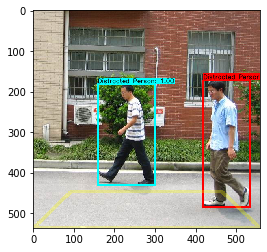

In [7]:
#EVAL ONE IMAGE
image_org = 'FudanPed00001.jpg'
image_org = cv2.imread(image_org, 1)
image_org = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)
img_shape = np.shape(image_org)[:2]
bboxes = ['160', '182', '302', '431', '420', '171', '535', '486']
bboxes = np.array(bboxes).astype(int)
bboxes = np.reshape(bboxes, (-1,4))
classes = ['Distracted Person', 'Distracted Person']
y_true = {'classes':classes, 'bboxes':bboxes}
image, y_true['bboxes'] = image_preprocess(image_org, y_true['bboxes'])
scale1, scale2, scale3 = ground_truth_preprocess(y_true['classes'], y_true['bboxes'])
start_postprocess = time.time()
scale1 = tf.reshape(scale1, (-1, 5+len(CLASSES_LIST)))
scale2 = tf.reshape(scale2, (-1, 5+len(CLASSES_LIST)))
scale3 = tf.reshape(scale3, (-1, 5+len(CLASSES_LIST)))
scale1 = bbox_back_to_scale(scale1)
scale2 = bbox_back_to_scale(scale2)
scale3 = bbox_back_to_scale(scale3)
y = tf.concat([scale1, scale2, scale3], 0)
y = non_max_suppression(y)
y = bboxes_postprocess(y, img_shape)
image = draw_bboxes(y, image_org)
image = draw_danger_zone(image)
plt.imshow(image);
stop_postprocess = time.time()
print('postprocess: {} s'.format(round(stop_postprocess - start_postprocess, 3)))

## Training the model
We train the model using the mean squared error loss function, as the [original publication](https://arxiv.org/abs/1804.02767) suggests.

In [8]:
checkpoint_path = "yolov3_coco.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Save weights, every 5-epochs.
    save_freq=5)

In [9]:
inputs = tf.keras.Input(shape=(INPUT_SIZE, INPUT_SIZE, 3))
scale1, scale2, scale3 = darknet53(inputs) # shape = (None, 52*52*3, 5 + num classes)
model = tf.keras.Model(inputs=inputs, outputs=[scale1, scale2, scale3])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mean_squared_error', #the function is applied for each output
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Replace the three arrays `train_scale1`,`train_scale2` and `train_scale3` with the ground truths of the data set for each scale.

In [ ]:
# train
model.fit(train_images, [train_scale1, train_scale2, train_scale3],
                    batch_size=12,
                    epochs=30,
                    validation_split=0.2,
                    callbacks = [cp_callback])

## Load pre-trained weights
We load pre-trained weights on the [COCO Dataset](http://cocodataset.org/) available on the [original YOLOv3 website](https://pjreddie.com/darknet/yolo/).

In [73]:
#Load pre-trained weights
with open('yolov3.weights', "rb") as fp:
    pretrained_weights = np.fromfile(fp, dtype=np.float32)
print('Number of pretrained weights from Darknet : {}'.format(np.shape(pretrained_weights)[0]))
used_weights = 0
for i in range(len(model.layers)):
    layer_weights = model.layers[i].get_weights()
    weights = []
    for j in range(len(layer_weights)):
        w = layer_weights[j]
        shape_w = np.shape(w)
        w = np.reshape(w, (1,-1))
        nb_w = np.shape(w)[1]
        new_weights = pretrained_weights[used_weights:used_weights + nb_w]
        new_weights = np.reshape(new_weights, shape_w)
        weights.append(new_weights)
        used_weights+=nb_w
    weights = np.array(weights)
    model.layers[i].set_weights(weights)
print('{} weights used.'.format(used_weights))

Number of pretrained weights from Darknet : 62001762
46642181 weights used.


We can also load weights from previous trainings:

In [9]:
#LOAD WEIGHTS
model.load_weights('weights/weights.h5')

## Testing the model
We test how the model performs on the test dataset (replace the inputs by the right arrays).

In [349]:
test_loss = model.evaluate(test_images, [test_scale1, test_scale2, test_scale3], verbose=2, batch_size = 10)
print('Test loss:', test_loss)

78/78 - 36s - loss: 157514.8117 - concatenate_97_loss: 395.5134 - concatenate_98_loss: 1419.2120 - concatenate_99_loss: 157114.5938 - concatenate_97_accuracy: 0.4320 - concatenate_98_accuracy: 0.0024 - concatenate_99_accuracy: 0.0089
Test loss: [157514.81169871794, 395.51343, 1419.212, 157114.6, 0.4320048, 0.002446518, 0.00887574]


## Running inference
We can then run inference on the model we just trained

In [ ]:
start_preprocess = time.time()

image_org = 'FudanPed00001.jpg'
image_org = cv2.imread(image_org, 1)
image_org = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)
img_shape = np.shape(image_org)[:2]
bboxes = ['160', '182', '302', '431', '420', '171', '535', '486']
bboxes = np.array(bboxes).astype(int)
bboxes = np.reshape(bboxes, (-1,4))
image, _ = image_preprocess(image_org, bboxes)
image = tf.convert_to_tensor(image)
image = tf.reshape(image, (1, INPUT_SIZE, INPUT_SIZE, 3))

start_prediction = time.time()
scale1, scale2, scale3 = model.predict(image) # (1,52*52*3,5+num_classes) -> deja decode
start_postprocess = time.time()
scale1 = bbox_back_to_scale(scale1[0])
scale2 = bbox_back_to_scale(scale2[0])
scale3 = bbox_back_to_scale(scale3[0])
y = tf.concat([scale1, scale2, scale3], 0)
y = non_max_suppression(y)
print(y)
y = bboxes_postprocess(y, img_shape)
image_org = draw_danger_zone(image_org)
image = draw_bboxes(y, image_org)
plt.imshow(image_org);
stop = time.time()
print('preprocess: {} s'.format(round(start_prediction - start_preprocess, 3)))
print('prediction: {} s'.format(round(start_postprocess - start_prediction, 3)))
print('post-process: {} s'.format(round(stop - start_postprocess, 3)))
print('total time: {} s'.format(round(stop - start_preprocess, 3)))
print('fps: {}'.format(round(1/(stop - start_preprocess), 3)))

## Saving the weights from our training

In [21]:
#SAVE WEIGHTS
model.save_weights('weights_{}.h5'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")))